# 动手实现线性回归

In [1]:
import random
import torch
from d2l import torch as d2l

生成数据
函数中定义一个 样品数*w长度 的张量，通过张量进行内积运算加bias生成label，在理论讲解中w是用于预测label的特征
然后调用函数进行生成得到1000个数据点，初始参数如下

In [2]:
def synthetic_data(w, b, num_examples):
    """生成 y= Xw + b + 噪声"""
    x = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(x, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return x, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-1.4300, -1.4156]) 
label: tensor([6.1532])


通过图形化观察一下数据点的大概分布

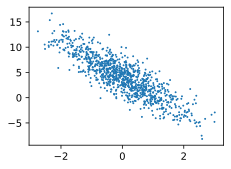

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1);

在下面的函数中做了这样一件事：输入批量大小、特征矩阵、标签，获取特征矩阵的长度得到总的样品数量（上面的例子中为1000），生成标签索引，然后打乱顺序，从0到样品总数进行读取，每次读取以设定好的批量大小为一个tensor。

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

下面的循环我们只读取第一个小批量的数据，打印出来看看

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.3675,  0.9081],
        [-0.0452, -0.0388],
        [-1.6917, -0.4951],
        [ 1.4959,  0.5098],
        [-0.3964,  1.6008],
        [-1.1313, -2.5315],
        [-0.4711, -2.3090],
        [-0.4362,  0.4261],
        [ 0.8211, -0.1672],
        [ 0.1617,  1.8488]]) 
 tensor([[ 0.3720],
        [ 4.2564],
        [ 2.5022],
        [ 5.4711],
        [-2.0375],
        [10.5188],
        [11.0981],
        [ 1.8931],
        [ 6.3896],
        [-1.7599]])


注意：在上面的循环，执行效率其实很低，在深度学习框架中实现的内置迭代器效率要高得多

### 初始化模型参数

从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏执初始化为0。

In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# 参数requires_grad=True表明需要计算梯度

### 定义模型

这里我们要把模型的输入和输出关联起来，输入特征X和模型权重w的矩阵向量乘法后加上bias，注意bias是一个标量，这里使用了广播机制：一个向量加上一个标量，标量会被加到向量的每一个分量中去。

In [8]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 定义损失函数

我们可以回忆一下什么是梯度：损失函数的对于参数w的导数

我们首先定义损失函数如下

In [9]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

$$\begin{aligned} \mathbf{w} &\leftarrow \mathbf{w} -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right),\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_b l^{(i)}(\mathbf{w}, b)  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned}$$

### 定义优化算法

以参数集合、学习率、批量大小作为输入，对参数进行更新

In [10]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练

训练其实是在做这件事：
* 初始化参数
* 重复以下训练，直到完成
    * 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

而具体的计算梯度和更新参数我们通过上面的sgd函数完成，我们首先定义超参数（除模型本身的权重参数外，训练者可以定义的参数，这里为迭代周期个数num_epochs和学习率lr）在一个num_epochs中数据会遍历完一遍数据（以小批量的方式）

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [13]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) #初始化一个模型，计算损失
        l.sum().backward() #计算梯度
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.044470
epoch 2, loss 0.000175
epoch 3, loss 0.000051


到这里这个简单的模型训练已经完成，我们输出一下训练得到的参数与真实值之间的差，来看看我们的训练效果

In [14]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 9.1279e-04, -5.2214e-05], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)


# 线性回归的见解实现

当然，现在很多时候以上过程的实现都是使用库自动实现了，手搓的意义可能在于测试一下在面对具体问题的时候会不会比库实现更快，因为库的函数可能为了通用而慢一点。

In [15]:
import numpy as np
import torch 
from torch.utils import data
from d2l import torch as d2l

In [16]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

生成数据集有可以直接调用的函数，不用再手动实现

In [18]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个pytorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [19]:
# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))



初始化模型参数

In [20]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

定义损失函数&优化算法

In [21]:
loss = nn.MSELoss()

#输入参数可以通过net.parameters()获得
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [22]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step() #优化器更新参数
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000726
epoch 2, loss 0.000104
epoch 3, loss 0.000106


In [23]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([0.0011, 0.0006])
b的估计误差： tensor([0.0006])
